[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.6.0rc1/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.6.0rc1/tutorials/zh_cn/beginner/mindspore_dataset.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.6.0rc1/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.6.0rc1/tutorials/zh_cn/beginner/mindspore_dataset.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.6.0rc1/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.6.0rc1/tutorials/source_zh_cn/beginner/dataset.ipynb)

[基本介绍](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0rc1/beginner/introduction.html) || [快速入门](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0rc1/beginner/quick_start.html) || [张量 Tensor](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0rc1/beginner/tensor.html) || **数据加载与处理** || [网络构建](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0rc1/beginner/model.html) || [函数式自动微分](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0rc1/beginner/autograd.html) || [模型训练](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0rc1/beginner/train.html) || [保存与加载](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0rc1/beginner/save_load.html) || [Graph Mode加速](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0rc1/beginner/accelerate_with_static_graph.html) || [自动混合精度](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0rc1/beginner/mixed_precision.html) ||

# 数据加载与处理

数据是深度学习的基础，高质量的数据输入将在整个深度神经网络中起到积极作用。

MindSpore提供基于Pipeline的[数据引擎](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/design/data_engine.html)，通过 `数据集（Dataset）`、`数据变换（Transforms）`和`数据批处理（Batch）`实现高效的数据预处理。其中：

1. 数据集（Dataset）是Pipeline的起始，用于从存储中加载原始数据至内存中，`mindspore.dataset`提供了内置的图像、文本、音频等[数据集加载接口](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/mindspore.dataset.loading.html#)，并提供了[自定义数据集加载接口](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/mindspore.dataset.loading.html#%E8%87%AA%E5%AE%9A%E4%B9%89%E6%95%B0%E6%8D%AE%E9%9B%86%E5%8A%A0%E8%BD%BD-1)；

2. 数据变换（Transforms）对内存中的数据做进一步的变换操作，`mindspore.dataset.transforms`提供[通用的数据变换操作](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/mindspore.dataset.transforms.html#%E9%80%9A%E7%94%A8)、`mindspore.dataset.transforms.vision`提供[图像数据变换操作](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/mindspore.dataset.transforms.html#%E8%A7%86%E8%A7%89)、`mindspore.dataset.transforms.text`提供[文本数据变换操作](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/mindspore.dataset.transforms.html#%E6%96%87%E6%9C%AC)、`mindspore.dataset.transforms.audio`提供[音频数据变换操作](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/mindspore.dataset.transforms.html#%E9%9F%B3%E9%A2%91)；

3. 数据批处理（Batch）完成对变换后的数据组批处理（Batch），用于最终的神经网络训练，Batch操作是针对一个数据集对象，其接口可参考：[batch操作](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/dataset/mindspore.dataset.MindDataset.html#batch%E6%89%B9%E6%93%8D%E4%BD%9C)；

4. 数据集迭代器是将最后的数据通过迭代的方式输出，迭代器也是针对一个数据集对象，其接口可参考：[迭代器](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/dataset/mindspore.dataset.MindDataset.html#%E8%BF%AD%E4%BB%A3%E5%99%A8)。

此外MindSpore的领域开发库也提供了大量的预加载数据集，可以使用API一键下载使用。本教程将分别对不同的数据集（Dataset）加载方式：自定义数据集、标准格式数据集和常见数据集，数据变换（Transforms）和数据batch方法进行详细阐述。

In [50]:
import os
import numpy as np
from mindspore import dtype as mstype
from mindspore.dataset import transforms
from mindspore.dataset import vision
from mindspore.dataset import MindDataset, GeneratorDataset, MnistDataset, NumpySlicesDataset
from mindspore.mindrecord import FileWriter
import matplotlib.pyplot as plt

## 数据集加载

`mindspore.dataset`模块提供了自定义数据集、标准格式数据集和一些常用的公开数据集的加载API。

### 自定义数据集

对于MindSpore暂不支持直接加载的数据集，可以构造自定义数据加载类或自定义数据集生成函数的方式来生成数据集，然后通过`GeneratorDataset`接口实现自定义方式的数据集加载。

`GeneratorDataset`支持通过可随机访问数据集对象、可迭代数据集对象和生成器(generator)构造自定义数据集，下面分别对其进行介绍。

#### 可随机访问数据集

可随机访问数据集是实现了`__getitem__`和`__len__`方法的数据集，表示可以通过索引/键直接访问对应位置的数据样本。

例如，当使用`dataset[idx]`访问这样的数据集时，可以读取dataset内容中第idx个样本或标签。

In [51]:
# Random-accessible object as input source
class RandomAccessDataset:
    def __init__(self):
        self._data = np.ones((5, 2))
        self._label = np.zeros((5, 1))
    def __getitem__(self, index):
        return self._data[index], self._label[index]
    def __len__(self):
        return len(self._data)

loader = RandomAccessDataset()
dataset = GeneratorDataset(source=loader, column_names=["data", "label"])

for data in dataset:
    print(data)

[Tensor(shape=[2], dtype=Float64, value= [ 1.00000000e+00,  1.00000000e+00]), Tensor(shape=[1], dtype=Float64, value= [ 0.00000000e+00])]
[Tensor(shape=[2], dtype=Float64, value= [ 1.00000000e+00,  1.00000000e+00]), Tensor(shape=[1], dtype=Float64, value= [ 0.00000000e+00])]
[Tensor(shape=[2], dtype=Float64, value= [ 1.00000000e+00,  1.00000000e+00]), Tensor(shape=[1], dtype=Float64, value= [ 0.00000000e+00])]
[Tensor(shape=[2], dtype=Float64, value= [ 1.00000000e+00,  1.00000000e+00]), Tensor(shape=[1], dtype=Float64, value= [ 0.00000000e+00])]
[Tensor(shape=[2], dtype=Float64, value= [ 1.00000000e+00,  1.00000000e+00]), Tensor(shape=[1], dtype=Float64, value= [ 0.00000000e+00])]


In [52]:
# list, tuple are also supported.
loader = [np.array(0), np.array(1), np.array(2)]
dataset = GeneratorDataset(source=loader, column_names=["data"])

for data in dataset:
    print(data)

[Tensor(shape=[], dtype=Int32, value= 2)]
[Tensor(shape=[], dtype=Int32, value= 0)]
[Tensor(shape=[], dtype=Int32, value= 1)]


#### 可迭代数据集

可迭代的数据集是实现了`__iter__`和`__next__`方法的数据集，表示可以通过迭代的方式逐步获取数据样本。这种类型的数据集特别适用于随机访问成本太高或者不可行的情况。

例如，当使用`iter(dataset)`的形式访问数据集时，可以读取从数据库、远程服务器返回的数据流。

下面构造一个简单迭代器，并将其加载至`GeneratorDataset`。

In [53]:
# Iterator as input source
class IterableDataset():
    def __init__(self, start, end):
        '''init the class object to hold the data'''
        self.start = start
        self.end = end
    def __next__(self):
        '''iter one data and return'''
        return next(self.data)
    def __iter__(self):
        '''reset the iter'''
        self.data = iter(range(self.start, self.end))
        return self

loader = IterableDataset(1, 5)
dataset = GeneratorDataset(source=loader, column_names=["data"])

for d in dataset:
    print(d)

[Tensor(shape=[], dtype=Int32, value= 1)]
[Tensor(shape=[], dtype=Int32, value= 2)]
[Tensor(shape=[], dtype=Int32, value= 3)]
[Tensor(shape=[], dtype=Int32, value= 4)]


#### 生成器

生成器也属于可迭代的数据集类型，其直接依赖Python的生成器类型`generator`返回数据，直至生成器抛出`StopIteration`异常。

下面构造一个生成器，并将其加载至`GeneratorDataset`。

In [54]:
# Generator
def my_generator(start, end):
    for i in range(start, end):
        yield i

# since a generator instance can be only iterated once, we need to wrap it by lambda to generate multiple instances
dataset = GeneratorDataset(source=lambda: my_generator(3, 6), column_names=["data"])

for d in dataset:
    print(d)

[Tensor(shape=[], dtype=Int32, value= 3)]
[Tensor(shape=[], dtype=Int32, value= 4)]
[Tensor(shape=[], dtype=Int32, value= 5)]


### 标准格式数据集

对于MindSpore暂不支持直接加载的数据集，可以将数据集转换成**MindRecord格式**数据集，然后通过`MindDataset`接口实现数据集加载。

首先通过**MindRecord格式**接口[FileWriter](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/mindspore.mindrecord.html#mindspore.mindrecord.FileWriter)创建一个新的**MindRecord格式**数据集，其中每个样本包含`file_name`、`label`和`data`三个字段。

In [55]:
if os.path.exists("./test.mindrecord"):
    os.remove("./test.mindrecord")
if os.path.exists("./test.mindrecord.db"):
    os.remove("./test.mindrecord.db")
writer = FileWriter(file_name="test.mindrecord", shard_num=1, overwrite=True)
schema_json = {"file_name": {"type": "string"},
               "label": {"type": "int32"},
               "data": {"type": "int32", "shape": [-1]}}
writer.add_schema(schema_json, "test_schema")
for i in range(4):
    data = [{"file_name": str(i) + ".jpg",
             "label": i,
             "data": np.array([i]*(i+1), dtype=np.int32)}]
    writer.write_raw_data(data)
writer.commit()

然后通过**MindDataset**接口读取**MindRecord格式**数据集。

In [56]:
dataset = MindDataset("test.mindrecord", shuffle=False)
for data in dataset:
    print(data)

[Tensor(shape=[1], dtype=Int32, value= [0]), Tensor(shape=[], dtype=String, value= '0.jpg'), Tensor(shape=[], dtype=Int32, value= 0)]
[Tensor(shape=[2], dtype=Int32, value= [1, 1]), Tensor(shape=[], dtype=String, value= '1.jpg'), Tensor(shape=[], dtype=Int32, value= 1)]
[Tensor(shape=[3], dtype=Int32, value= [2, 2, 2]), Tensor(shape=[], dtype=String, value= '2.jpg'), Tensor(shape=[], dtype=Int32, value= 2)]
[Tensor(shape=[4], dtype=Int32, value= [3, 3, 3, 3]), Tensor(shape=[], dtype=String, value= '3.jpg'), Tensor(shape=[], dtype=Int32, value= 3)]


### 常用数据集

我们使用**Mnist**数据集作为样例，介绍使用常用数据集的加载方法。

`mindspore.dataset`提供的接口**仅支持解压后的数据文件**，因此我们使用`download`库下载数据集并解压。

In [57]:
# Download data from open datasets
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:01<00:00, 5.78MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


压缩文件删除后，直接加载，可以看到其数据类型为MnistDataset。

In [58]:
train_dataset = MnistDataset("MNIST_Data/train", shuffle=False)
print(type(train_dataset))

<class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>


使用迭代器循环输出数据，下面定义一个可视化函数，迭代**Mnist**数据集中9张图片进行展示。

In [59]:
def visualize(dataset):
    figure = plt.figure(figsize=(4, 4))
    cols, rows = 3, 3

    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    for idx, (image, label) in enumerate(dataset.create_tuple_iterator()):
        figure.add_subplot(rows, cols, idx + 1)
        plt.title(int(label))
        plt.axis("off")
        plt.imshow(image.asnumpy().squeeze(), cmap="gray")
        if idx == cols * rows - 1:
            break
    plt.show()

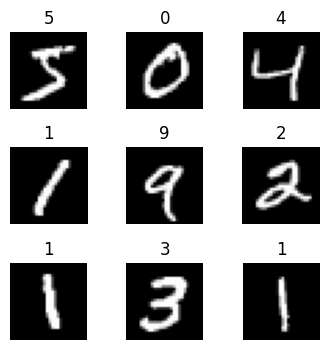

In [60]:
visualize(train_dataset)

## 数据变换

通常情况下，直接加载的原始数据并不能直接送入神经网络进行训练，此时我们需要对其进行数据预处理。MindSpore提供不同种类的数据变换（Transforms），配合数据处理Pipeline来实现数据预处理，所有的Transforms均可通过`.map(...)`方法传入。

1. `.map(...)`操作可以针对数据集指定列（column）添加数据变换（Transforms），将数据变换应用于该列数据的每个元素，并返回包含变换后元素的新数据集。

2. `.map(...)`操作可以执行Dataset模块提供的内置数据变换操作，也可以执行用户自定义的变换操作。

`mindspore.dataset`提供了面向图像、文本、音频等不同数据类型的内置数据变换操作，同时也支持使用自定义数据变换操作。下面分别对其进行介绍。

### 内置数据变换操作

`mindspore.dataset`提供的内置数据变换：[vision数据变换](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/mindspore.dataset.transforms.html#%E8%A7%86%E8%A7%89) ， [nlp数据变换](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/mindspore.dataset.transforms.html#%E6%96%87%E6%9C%AC) ， [audio数据变换](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/mindspore.dataset.transforms.html#%E9%9F%B3%E9%A2%91)。

下面举例对**Mnist**数据集中**data**使用 `Rescale`、`Normalize`和`HWC2CHW`操作，对**label**使用`TypeCast`操作。

1. Rescale：用于调整图像像素值的大小，包括两个参数：rescale（缩放因子）和shift（平移因子），图像的每个像素将根据这两个参数进行调整，输出的像素值为$output_{i} = input_{i} * rescale + shift$。

2. Normalize：用于对输入图像的归一化，包括三个参数：mean（图像每个通道的均值）、std（图像每个通道的标准差）和is_hwc（bool值，输入图像的格式。True为(height, width, channel)，False为(channel, height, width)）。图像的每个通道将根据mean和std进行调整，计算公式为 $output_{c} = \frac{input_{c} - mean_{c}}{std_{c}}$ ，其中 $c$ 代表通道索引。

3. HWC2CHW：用于转换图像格式，将图像从HWC转换成CHW。

In [61]:
train_dataset = MnistDataset('MNIST_Data/train')
train_dataset = train_dataset.map(operations=[vision.Rescale(1.0 / 255.0, 0),
                                              vision.Normalize(mean=(0.1307,), std=(0.3081,)),
                                              vision.HWC2CHW()],
                                  input_columns=['image'])
train_dataset = train_dataset.map(operations=[transforms.TypeCast(mstype.int32)],
                                  input_columns=['label'])
for data in train_dataset:
    print(data[0].shape, data[0].dtype)
    print(data[1].shape, data[1].dtype)
    break

(1, 28, 28) Float32
() Int32


### 自定义数据变换操作

下面举例对**Mnist**数据集中**data**使用 自定义的`Rescale`、自定义的`Normalize`和 自定义的`HWC2CHW`操作，对**label**使用自定义的`TypeCast`操作。

In [62]:
train_dataset = MnistDataset('MNIST_Data/train')
def rescale_normalize_hwc2chw(input_col):
    trans_result = input_col / 255.0
    trans_result = (trans_result - 0.1307) / 0.3081
    trans_result = trans_result.transpose(2, 0, 1)
    return trans_result.astype(np.float32)
train_dataset = train_dataset.map(operations=rescale_normalize_hwc2chw,
                                  input_columns=['image'])
def typecast(input_col):
    trans_result = input_col.astype(np.int32)
    return trans_result
train_dataset = train_dataset.map(operations=typecast,
                                  input_columns=['label'])
for data in train_dataset:
    print(data[0].shape, data[0].dtype)
    print(data[1].shape, data[1].dtype)
    break

(1, 28, 28) Float32
() Int32


## 数据batch

Batch意义在于将多个样本打包为固定大小的`batch`（批次）。这是在有限硬件资源下使用梯度下降进行模型优化的折中方法，既保证了梯度下降的随机性，又优化了计算量。

一般我们会设置一个固定的batch size，将连续的数据分为若干批（batch）。batch后的数据增加一维，大小为`batch_size`。

![op-batch](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.6.0rc1/tutorials/source_zh_cn/dataset/images/op_batch.png)

In [63]:
data = ([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]], [0, 1, 0, 1, 0, 1])
dataset = NumpySlicesDataset(data=data, column_names=["data", "label"], shuffle=False)
dataset = dataset.batch(2)
for data in dataset.create_tuple_iterator():
    print(data[0].shape, data[1].shape)

(2, 2) (2,)
(2, 2) (2,)
(2, 2) (2,)


## 数据集迭代器

数据集Pipeline定义完成后，一般以迭代方式获取数据，然后送入神经网络中进行训练。我们可以用[create_tuple_iterator](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/dataset/dataset_method/iterator/mindspore.dataset.Dataset.create_tuple_iterator.html)或[create_dict_iterator](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/dataset/dataset_method/iterator/mindspore.dataset.Dataset.create_dict_iterator.html)接口创建数据迭代器，并迭代访问数据。

访问的数据类型默认为`Tensor`；若设置`output_numpy=True`，访问的数据类型为`Numpy`。

下面展示`create_tuple_iterator`迭代器输出的结果。

In [64]:
data = ([1, 2, 3, 4, 5, 6, 7, 8], [0, 1, 0, 1, 0, 1, 0, 1])
dataset = NumpySlicesDataset(data=data, column_names=["data", "label"], shuffle=False)
dataset = dataset.map(lambda x: x * 2, input_columns=["data"])
dataset = dataset.batch(2)
for data in dataset.create_tuple_iterator():
    print(data)

[Tensor(shape=[2], dtype=Int32, value= [2, 4]), Tensor(shape=[2], dtype=Int32, value= [0, 1])]
[Tensor(shape=[2], dtype=Int32, value= [6, 8]), Tensor(shape=[2], dtype=Int32, value= [0, 1])]
[Tensor(shape=[2], dtype=Int32, value= [10, 12]), Tensor(shape=[2], dtype=Int32, value= [0, 1])]
[Tensor(shape=[2], dtype=Int32, value= [14, 16]), Tensor(shape=[2], dtype=Int32, value= [0, 1])]


下面展示`create_dict_iterator`迭代器输出的结果。

In [65]:
data = ([1, 2, 3, 4, 5, 6, 7, 8], [0, 1, 0, 1, 0, 1, 0, 1])
dataset = NumpySlicesDataset(data=data, column_names=["data", "label"], shuffle=False)
dataset = dataset.map(lambda x: x * 2, input_columns=["data"])
dataset = dataset.batch(2)
for data in dataset.create_dict_iterator():
    print(data)

{'data': Tensor(shape=[2], dtype=Int32, value= [2, 4]), 'label': Tensor(shape=[2], dtype=Int32, value= [0, 1])}
{'data': Tensor(shape=[2], dtype=Int32, value= [6, 8]), 'label': Tensor(shape=[2], dtype=Int32, value= [0, 1])}
{'data': Tensor(shape=[2], dtype=Int32, value= [10, 12]), 'label': Tensor(shape=[2], dtype=Int32, value= [0, 1])}
{'data': Tensor(shape=[2], dtype=Int32, value= [14, 16]), 'label': Tensor(shape=[2], dtype=Int32, value= [0, 1])}
